#QN2

A problem was faced with modifying existing plots. To overcome it, plots and widgets are deleted and redrawn everytime the widgets are manipulated. To aid this, an additional function 'clear_output()' is imported from 'IPython.display'

JAX, Matplotlib, ipywidgets are imported. 

In [114]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import jax
from IPython.display import clear_output
%matplotlib inline

Below, the plot parameters are initialized(axis limits, number of histogram bins etc..)


In [115]:
global Cov, limit, instances, num_bins, samples
limit=4.5; # X and Y axis plot limits
instances=5000; # Number of sample instances for the scatter plot
num_bins=16; # Number of bins for the histogram plot

# Randomness for the entire code
key = jax.random.PRNGKey(0)
subkey, key = jax.random.split(key)

Mean and covariance of the bivariate gaussian is initialized to 0 and identity respectively. 

Then the standard bivariate gaussian is sampled

In [116]:
# Initializing mean and covariance
mean = jax.numpy.zeros([2])
Cov = jax.numpy.zeros([2,2])
Cov = Cov.at[0,0].set(1)
Cov = Cov.at[1,1].set(1)

samples = jax.random.multivariate_normal(subkey, jax.numpy.zeros([1,2]), Cov, (instances,)) # Sampling of standard bivariate gaussian

The below function creates all widgets. The arguments passed in order are,
*   variance of X(inital value)
*   covariance of X and Y(inital value)
*   variance of Y(inital value)
*   Limits of the covariance slider
*   mean of X
*   mean of Y


There are a total of 5 FloatSliders, 3 to specify the covariance matrix, 2 to specify the means.

In [117]:
def create_slider(Exx,Exy,Eyy,Exy_limit,Ex,Ey):
  # Creating all 5 widgets.
  xx_slider = widgets.FloatSlider(value=Exx, min=0, max=4, step=0.1, description='Cxx')
  xy_slider = widgets.FloatSlider(value=Exy, min=-Exy_limit, max=Exy_limit, step=0.1, description='Cxy')
  yy_slider = widgets.FloatSlider(value=Eyy, min=0, max=4, step=0.1, description='Cyy')
  x_slider = widgets.FloatSlider(value=Ex, min=-3, max=3, step=0.1, description='E(X)')
  y_slider = widgets.FloatSlider(value=Ey, min=-3, max=3, step=0.1, description='E(Y)')

  # Displaying all 5 widgets
  display(xx_slider)
  display(xy_slider)
  display(yy_slider)
  display(x_slider)
  display(y_slider)

  # Observing all 5 widgets
  xx_slider.observe(xx_update, 'value')
  xy_slider.observe(xy_update, 'value')
  yy_slider.observe(yy_update, 'value')
  x_slider.observe(x_update, 'value')
  y_slider.observe(y_update, 'value')

This function deletes all previous outputs(including widgets) and figures and replots them. As specified before this approach was taken due to a problem involving modifying plots in existing figures

In [118]:
def plotter():
  global mean, Cov, limit, instances, num_bins

  # Deleting all outputs and redrawing all widgets with previous slider values.
  clear_output(wait = True)
  create_slider(Cov[0,0], Cov[0,1], Cov[1,1], jax.numpy.sqrt(Cov[0,0]*Cov[1,1]), mean[0], mean[1])


  # SETTING UP THE FIGURE HERE
  fig=plt.figure(1)
  ax = plt.axes(projection='3d')
  ax.view_init(45, 315) # The same view as given in the problem image
  ax.set_xlim(-limit, limit)
  ax.set_ylim(-limit, limit)
  # Setting up axes ticks similar to the ones in the problem image
  major_ticks = jax.numpy.arange(-4, 4, 0.1)
  ax.set_zticks(major_ticks)
  ax.zaxis._axinfo["grid"].update({"linewidth":0.3, "which":"major", "linstyle":":", "color":"black"})
  major_ticks = jax.numpy.arange(-limit, limit+0.01, limit*2/4.5)
  ax.set_xticks(major_ticks)
  ax.xaxis._axinfo["grid"].update({"linewidth":0.3, "which":"major", "linstyle":":", "color":"black"})
  ax.set_yticks(major_ticks)
  ax.yaxis._axinfo["grid"].update({"linewidth":0.3, "which":"major", "linstyle":":", "color":"black"})
  # Plot labels
  plt.xlabel("X")
  plt.ylabel("Y")


  # CALCULATING AND PLOTTING THE X PDF HERE
  points = jax.numpy.linspace(-limit, limit, 100)
  # This 'dummy' variable is used in the plot to specify the unchanging coordinate('y' in this case)
  dummy = jax.numpy.zeros([100])+limit
  X_pdf = jax.numpy.multiply(points-mean[0], points-mean[0])
  X_pdf = X_pdf / (-2*Cov[0,0])
  X_pdf = jax.numpy.exp(X_pdf)
  X_pdf = X_pdf / jax.numpy.sqrt(2*jax.numpy.pi*Cov[0,0])
  X_PDF_plot = ax.plot3D(points, dummy, X_pdf, color='blue')
  ax.set_zlabel("p(X)")


  # CALCULATING AND PLOTTING THE Y PDF HERE
  Y_pdf = jax.numpy.multiply(points-mean[1], points-mean[1])
  Y_pdf = Y_pdf/(-2*Cov[1,1])
  Y_pdf = jax.numpy.exp(Y_pdf)
  Y_pdf = Y_pdf / jax.numpy.sqrt(2*jax.numpy.pi*Cov[1,1])
  ax.plot3D(-dummy, points, Y_pdf, color='red')
  ax.set_zlabel("p(Y)")


  # CALCULATING AND PLOTTING THE JOINT PDF CONTOUR HERE
  # The approach is as follows,
    # Create plot points of a unit circle in the xy cordinates
    # Convert the circle into the eigen-vector basis
    # Scale the circle cordinates by the corresponding eigen-values
    # Recovert the circle back into the xy cordinates
  eig_values, eig_vectors = jax.numpy.linalg.eig(Cov)
  eig_values = jax.numpy.real(eig_values)
  eig_vectors = jax.numpy.real(eig_vectors)
  eig_points = jax.numpy.zeros([2,100])
  # Contour in eigen vector basis(variable 'eig_points')
  eig_points = eig_points.at[0,:].set(2.5 * jax.numpy.sqrt(eig_values[0]) * jax.numpy.sin(jax.numpy.linspace(0, 2*jax.numpy.pi, 100)))
  eig_points = eig_points.at[1,:].set(2.5 * jax.numpy.sqrt(eig_values[1]) * jax.numpy.cos(jax.numpy.linspace(0, 2*jax.numpy.pi, 100)))
  plot_points = jax.numpy.zeros([2,100])
  # Convert contour to xy basis(variable 'plot_points')
  plot_points = jax.numpy.matmul(eig_vectors, eig_points)
  dummy = jax.numpy.zeros([100])
  plot_points = jax.numpy.real(plot_points)
  plt.plot(plot_points[0,:]+mean[0], plot_points[1,:]+mean[1], dummy, color='cyan')


  # PLOTTING THE SCATTERED SAMPLES HERE.
  # The approach is as follows,
    # The variable 'samples' contains samples of the standard bivariate gaussian
    # Convert the samples into the eigen-vector basis
    # Scale the samples by the corresponding eigen-values
    # Recovert the samples back into the xy cordinates and add mean
  samples_copy = jax.numpy.transpose(jax.numpy.matmul(jax.numpy.transpose(eig_vectors), jax.numpy.transpose(samples)))
  samples_copy = samples_copy.at[:,0].set(samples_copy[:,0] * jax.numpy.sqrt(eig_values[0]))
  samples_copy = samples_copy.at[:,1].set(samples_copy[:,1] * jax.numpy.sqrt(eig_values[1]))
  samples_copy = jax.numpy.transpose(jax.numpy.matmul(eig_vectors, jax.numpy.transpose(samples_copy)))
  samples_copy = samples_copy.at[:,0].add(mean[0])
  samples_copy = samples_copy.at[:,1].add(mean[1])
  dummy = jax.numpy.zeros([1, instances])
  ax.scatter3D(samples_copy[:,0], samples_copy[:,1], dummy, color = "black", marker='.', s=3, alpha=0.2)


  # PLOTTING THE X_HISTOGRAM HERE
  # This function returns the heights and endpoints of the histogram bars
  bars, axes = jax.numpy.histogram(samples_copy[:,0], num_bins)
  heights = []
  flats = []
  dummy = []
  bars = bars / (instances*(axes[1]-axes[0]))
  # Using the bar endpoints and heights the bars are plotted
  for i in range(num_bins):
    if( (-limit<axes[i]<limit) & (-limit<axes[i+1]<limit) ):
      heights.extend([0, bars[i], bars[i], 0])
      flats.extend([axes[i]+0.15*(axes[1]-axes[0]), axes[i]+0.15*(axes[1]-axes[0]), axes[i+1]-0.15*(axes[1]-axes[0]), axes[i+1]-0.15*(axes[1]-axes[0])])
      dummy.extend([limit, limit, limit, limit])
  plt.plot(flats, dummy, heights, color='black', linewidth=0.8)

  # PLOTTING THE Y_HISTOGRAM HERE
  # This function returns the heights and endpoints of the histogram bars
  bars, axes = jax.numpy.histogram(samples_copy[:,1], num_bins)
  heights = []
  flats = []
  dummy = []
  bars = bars / (instances*(axes[1]-axes[0]))
  # Using the bar endpoints and heights the bars are plotted
  for i in range(num_bins):
    if( (-limit<axes[i]<limit) & (-limit<axes[i+1]<limit) ):
      heights.extend([0, bars[i], bars[i], 0])
      flats.extend([axes[i]+0.15*(axes[1]-axes[0]), axes[i]+0.15*(axes[1]-axes[0]), axes[i+1]-0.15*(axes[1]-axes[0]), axes[i+1]-0.15*(axes[1]-axes[0])])
      dummy.extend([-limit, -limit, -limit, -limit])
  plt.plot(dummy, flats, heights, color='black', linewidth=0.8)

These are the widget/slider trigger functions. Each slider has an individual function. The general goal of these functions is to modify their corresponding variables(mean and covariance) and then to call upon 'plotter()' which replots the figure with the new parameter values.

FloatSlider(value=1.0, description='Cxx', max=4.0)

FloatSlider(value=0.0, description='Cxy', max=1.0, min=-1.0)

FloatSlider(value=1.0, description='Cyy', max=4.0)

FloatSlider(value=0.0, description='E(X)', max=3.0, min=-3.0)

FloatSlider(value=0.0, description='E(Y)', max=3.0, min=-3.0)

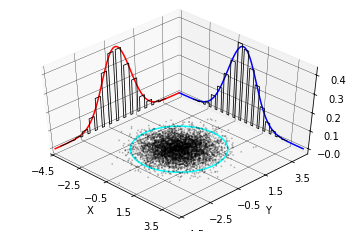

In [119]:
def xx_update(Exx): # Function corresponding to slider Cxx
  global Cov
  Cov = Cov.at[0:1,0:1].set(Exx.new)
  plotter()

def yy_update(Eyy): # Function corresponding to slider Cyy
  global Cov
  Cov = Cov.at[1,1].set(Eyy.new)
  plotter()

def xy_update(Exy): # Function corresponding to slider Cxy
  global Cov
  Cov = Cov.at[0,1].set(Exy.new)
  Cov = Cov.at[1,0].set(Exy.new)
  plotter()

def x_update(Ex): # Function corresponding to slider Ex
  global mean
  mean = mean.at[0].set(Ex.new)
  plotter()

def y_update(Ey): # Function corresponding to slider Ey
  global mean
  mean = mean.at[1].set(Ey.new)
  plotter()

#This is the run-time plotter
plotter()

Due to problem of replotting the figure after each slider manipulation, it is better to click on the slider positions than to drag the sliders. 

And avoid extreme low values of Cxx and Cyy as they cause unavailability of 
samples for histrogram